In [1]:
import pandas as pd
import numpy as np
import os

import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from transformers import TFBertModel
import transformers

2022-09-12 03:36:53.148858: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-12 03:36:53.149929: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-12 03:36:53.150682: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-12 03:36:53.152588: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [2]:
df_train = pd.read_csv("../input/feedback-prize-effectiveness/train.csv")
df_train['text'] = df_train['essay_id'].apply(lambda x: open(f'/kaggle/input/feedback-prize-effectiveness/train/{x}.txt').read())

df_test = pd.read_csv('../input/feedback-prize-effectiveness/test.csv')
df_test['text'] = df_test['essay_id'].apply(lambda x: open(f'/kaggle/input/feedback-prize-effectiveness/test/{x}.txt').read())

df_train.head()

,discourse_id,essay_id,discourse_text,discourse_type,discourse_effectiveness,text
0,0013cc385424,007ACE74B050,"Hi, i'm Isaac, i'm going to be writing about h...",Lead,Adequate,"Hi, i'm Isaac, i'm going to be writing about h..."
1,9704a709b505,007ACE74B050,"On my perspective, I think that the face is a ...",Position,Adequate,"Hi, i'm Isaac, i'm going to be writing about h..."
2,c22adee811b6,007ACE74B050,I think that the face is a natural landform be...,Claim,Adequate,"Hi, i'm Isaac, i'm going to be writing about h..."
3,a10d361e54e4,007ACE74B050,"If life was on Mars, we would know by now. The...",Evidence,Adequate,"Hi, i'm Isaac, i'm going to be writing about h..."
4,db3e453ec4e2,007ACE74B050,People thought that the face was formed by ali...,Counterclaim,Adequate,"Hi, i'm Isaac, i'm going to be writing about h..."


In [3]:
# Concatenate train & test, for process features easier
df_combined = pd.concat([df_train, df_test], axis=0, sort=False)
df_combined.head()

,discourse_id,essay_id,discourse_text,discourse_type,discourse_effectiveness,text
0,0013cc385424,007ACE74B050,"Hi, i'm Isaac, i'm going to be writing about h...",Lead,Adequate,"Hi, i'm Isaac, i'm going to be writing about h..."
1,9704a709b505,007ACE74B050,"On my perspective, I think that the face is a ...",Position,Adequate,"Hi, i'm Isaac, i'm going to be writing about h..."
2,c22adee811b6,007ACE74B050,I think that the face is a natural landform be...,Claim,Adequate,"Hi, i'm Isaac, i'm going to be writing about h..."
3,a10d361e54e4,007ACE74B050,"If life was on Mars, we would know by now. The...",Evidence,Adequate,"Hi, i'm Isaac, i'm going to be writing about h..."
4,db3e453ec4e2,007ACE74B050,People thought that the face was formed by ali...,Counterclaim,Adequate,"Hi, i'm Isaac, i'm going to be writing about h..."


# BERT

In [4]:
MODEL_PATH = '../input/huggingface-bert-variants/distilbert-base-cased/distilbert-base-cased'
MAX_TEXT = 256

In [5]:
# Load tokenizer.
tokenizer = transformers.BertTokenizer.from_pretrained(MODEL_PATH)
tokenizer.sep_token

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'DistilBertTokenizer'. 
The class this function is called from is 'BertTokenizer'.


'[SEP]'

In [6]:
# Create text feature to input to Bert.
df_combined['text'] = tokenizer.sep_token + df_combined['discourse_text']
df_combined.head()

,discourse_id,essay_id,discourse_text,discourse_type,discourse_effectiveness,text
0,0013cc385424,007ACE74B050,"Hi, i'm Isaac, i'm going to be writing about h...",Lead,Adequate,"[SEP]Hi, i'm Isaac, i'm going to be writing ab..."
1,9704a709b505,007ACE74B050,"On my perspective, I think that the face is a ...",Position,Adequate,"[SEP]On my perspective, I think that the face ..."
2,c22adee811b6,007ACE74B050,I think that the face is a natural landform be...,Claim,Adequate,[SEP]I think that the face is a natural landfo...
3,a10d361e54e4,007ACE74B050,"If life was on Mars, we would know by now. The...",Evidence,Adequate,"[SEP]If life was on Mars, we would know by now..."
4,db3e453ec4e2,007ACE74B050,People thought that the face was formed by ali...,Counterclaim,Adequate,[SEP]People thought that the face was formed b...


In [7]:
# Encode prediction target.
effectiveness_map = {"Ineffective":0, "Adequate":1,"Effective":2}
df_combined["target"] = df_combined["discourse_effectiveness"].map(effectiveness_map)

In [8]:
df_combined.head()

,discourse_id,essay_id,discourse_text,discourse_type,discourse_effectiveness,text,target
0,0013cc385424,007ACE74B050,"Hi, i'm Isaac, i'm going to be writing about h...",Lead,Adequate,"[SEP]Hi, i'm Isaac, i'm going to be writing ab...",1.0
1,9704a709b505,007ACE74B050,"On my perspective, I think that the face is a ...",Position,Adequate,"[SEP]On my perspective, I think that the face ...",1.0
2,c22adee811b6,007ACE74B050,I think that the face is a natural landform be...,Claim,Adequate,[SEP]I think that the face is a natural landfo...,1.0
3,a10d361e54e4,007ACE74B050,"If life was on Mars, we would know by now. The...",Evidence,Adequate,"[SEP]If life was on Mars, we would know by now...",1.0
4,db3e453ec4e2,007ACE74B050,People thought that the face was formed by ali...,Counterclaim,Adequate,[SEP]People thought that the face was formed b...,1.0


In [9]:
# deal with categorical features
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder

In [10]:
df_train.shape[0]

36765

In [11]:
# Selecting the first n ( df_train.shape[0] rows)
df_train_b = df_combined[:df_train.shape[0]]
df_test_b = df_combined[df_train.shape[0]:]

In [12]:
X_input_ids = np.zeros((len(df_train_b), MAX_TEXT))
X_attn_masks = np.zeros((len(df_train_b), MAX_TEXT))

In [13]:
from tqdm.auto import tqdm

def encode_data(df, ids, masks, tokenizer):
    for i, text in tqdm(enumerate(df['text'])):
        tokenized_text = tokenizer.encode_plus(
            text,
            max_length=MAX_TEXT, 
            truncation=True, 
            padding='max_length', 
            add_special_tokens=True,
            return_tensors='tf'
        )
#         Assigning the input_ids and attention mask for each text 
        ids[i, :] = tokenized_text.input_ids
        masks[i, :] = tokenized_text.attention_mask
    return ids, masks

In [14]:
# Creating the input ids and attention masks for the training dataset
X_input_ids, X_attn_masks = encode_data(df_train_b, X_input_ids, X_attn_masks, tokenizer)

0it [00:00, ?it/s]

In [15]:
#Converting all the labels to int (which I think they already are but check later)
df_train_b['target'] = df_train_b['target'].astype(int)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [16]:
# One hot encoding the Labels 
labels = np.zeros((len(df_train_b), 3))
labels[np.arange(len(df_train_b)), df_train_b['target'].values] = 1
labels

array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       ...,
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.]])

In [17]:
# Create dataset input for keras model.
def DatasetMapFunction(input_ids, attn_masks, labels):
    return {
        'input_ids': input_ids,  # From tokenizer, not yet converted to features.
        'attention_mask': attn_masks,  # From tokenizer, not yet converted to features.
#         'discourse_type': discourse_type,  # Manually created feature for discourse_type.
    }, labels  # Manually created labels.

# Tensorflow specific, need to combine tokenizer output and label to form training dataset.
dataset = tf.data.Dataset.from_tensor_slices((X_input_ids, X_attn_masks, labels))
dataset = dataset.map(DatasetMapFunction)  # Convert to required format for tensorflow dataset.
print(dataset)
dataset = dataset.shuffle(10000).batch(16, drop_remainder=True)
print(dataset)

<MapDataset shapes: ({input_ids: (256,), attention_mask: (256,)}, (3,)), types: ({input_ids: tf.float64, attention_mask: tf.float64}, tf.float64)>
<BatchDataset shapes: ({input_ids: (16, 256), attention_mask: (16, 256)}, (16, 3)), types: ({input_ids: tf.float64, attention_mask: tf.float64}, tf.float64)>


In [18]:
#creating the validation dataset for ensuring overfitting to not happen
ratio = 0.8
train_size = int((len(df_train_b) // 16) * ratio)
train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size)

In [19]:
# Load model.
from transformers import TFBertModel
model = TFBertModel.from_pretrained(MODEL_PATH)

You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some layers from the model checkpoint at ../input/huggingface-bert-variants/distilbert-base-cased/distilbert-base-cased were not used when initializing TFBertModel: ['vocab_layer_norm', 'vocab_transform', 'distilbert', 'activation_13', 'vocab_projector']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertModel were not initialized from the model checkpoint at ../input/huggingface-bert-variants/distilbert-base-cased

In [20]:
# Defines Bert layer. Input layer names must be the same as defined in dataset.
input_ids = tf.keras.layers.Input(shape=(MAX_TEXT,), name='input_ids', dtype='int32')  # Input layer.
attn_masks = tf.keras.layers.Input(shape=(MAX_TEXT,), name='attention_mask', dtype='int32')  # Input layer.
bert_embds = model.bert(input_ids, attention_mask=attn_masks)[1]
intermediate_layer = tf.keras.layers.Dense(512, activation='relu', name='intermediate_layer')(bert_embds)

output_layer = tf.keras.layers.Dense(3, activation='softmax', name='output_layer')(intermediate_layer)

In [21]:
feedback_model = tf.keras.Model(inputs=[input_ids, attn_masks], outputs=output_layer)
feedback_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 256)]        0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, 256)]        0                                            
__________________________________________________________________________________________________
bert (TFBertMainLayer)          TFBaseModelOutputWit 108310272   input_ids[0][0]                  
                                                                 attention_mask[0][0]             
__________________________________________________________________________________________________
intermediate_layer (Dense)      (None, 512)          393728      bert[0][1]                   

In [22]:
feedback_model.compile(optimizer=Adam(learning_rate = 1e-5, decay = 1e-6), loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [23]:
history = feedback_model.fit(
    train_dataset,
    steps_per_epoch = 10,
    validation_data = val_dataset,
    epochs = 1
)

2022-09-12 03:38:31.669683: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


10/10 [==============================] - 88s 9s/step - loss: 1.0892 - accuracy: 0.5312 - val_loss: 1.0542 - val_accuracy: 0.5428


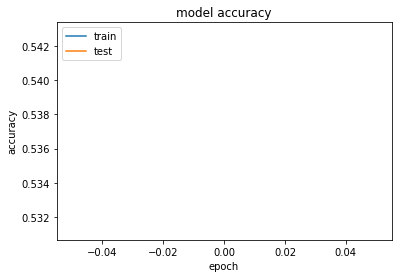

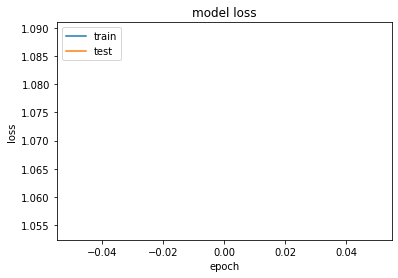

In [24]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [25]:
# Predict.

# Create features for Bert.
X_test_input_ids = np.zeros((len(df_test_b), MAX_TEXT))
X_test_attn_masks = np.zeros((len(df_test_b), MAX_TEXT))
for i, text in enumerate(df_test_b['text']):
        tokenized_text = tokenizer.encode_plus(
            text,
            max_length=MAX_TEXT, 
            truncation=True, 
            padding='max_length', 
            add_special_tokens=True,
            return_tensors='tf'
        )
        X_test_input_ids[i, :] = tokenized_text.input_ids
        X_test_attn_masks[i, :] = tokenized_text.attention_mask

# Create features for discourse_type.
# feature_discourse_type = np.zeros((len(df_test_b), unique_discourse_types))
# feature_discourse_type[np.arange(len(df_test_b)), df_test_b['discourse_type'].values] = 1

# Predict.
pred_labels = feedback_model.predict([X_test_input_ids, X_test_attn_masks])

In [26]:
pred_labels

array([[0.29944614, 0.50921434, 0.19133955],
       [0.32289746, 0.5142199 , 0.16288267],
       [0.32046032, 0.5261337 , 0.15340595],
       [0.30545008, 0.5257893 , 0.16876066],
       [0.3107304 , 0.52387375, 0.16539584],
       [0.31455162, 0.48939323, 0.19605514],
       [0.3136566 , 0.4907916 , 0.19555181],
       [0.30373538, 0.5196378 , 0.17662674],
       [0.3135438 , 0.4924441 , 0.19401208],
       [0.30621552, 0.50222504, 0.19155937]], dtype=float32)

In [27]:
sample_submission = pd.read_csv('/kaggle/input/feedback-prize-effectiveness/sample_submission.csv')
sample_submission['discourse_id'] = df_test_b['discourse_id']
sample_submission['Ineffective'] = pred_labels[:,0]
sample_submission['Adequate'] = pred_labels[:,1]
sample_submission['Effective'] = pred_labels[:,2]
sample_submission.to_csv("submission.csv", index=False)